<a href="https://colab.research.google.com/github/zlximon/Tensorflow_DL/blob/master/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

In [199]:
#download helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-04 15:25:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-04 15:25:06 (63.6 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [200]:
#download the Dataset
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [201]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [202]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


In [203]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

#Preprocess data


In [204]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [205]:
train_lines=get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [206]:
len(train_lines)

210040

In [207]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentnece,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text 
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [208]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 459 ms, sys: 123 ms, total: 582 ms
Wall time: 583 ms


In [209]:
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

#Get lists of sentences


In [210]:
 #trun data into a DataFram
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [211]:
#Distribution of labels 
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

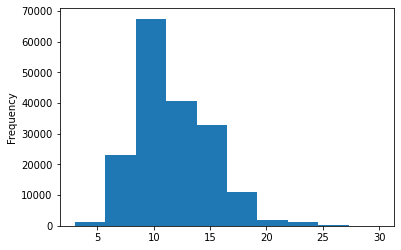

In [212]:
#let's check the length of diffrent lines
train_df.total_lines.plot.hist()

In [213]:
#get list of sentences 
train_sentences =train_df["text"].tolist()
val_sentences=val_df["text"].tolist()
test_sentences=test_df["text"].tolist()

In [214]:
len(train_sentences), len(val_sentences), len(test_sentences)



(180040, 30212, 30135)

In [215]:
#veiw the 10 lines of training sentence
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

#Make numeric labels

In [216]:
#one hot incode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse=False)#tensorflow is incommpatible with Sparse datafile so we need set sparse to False
train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))



#Label encode labels


In [217]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [218]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder 
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded


array([3, 2, 2, ..., 4, 1, 1])

In [219]:
#get Class names
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes,class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

#Model 0 Baseline 

In [220]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [221]:
#evaluate model0 on validation Data
model_0.score(X=val_sentences,y=val_labels_encoded)

0.7218323844829869

In [222]:
#Make prediction 
baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [223]:
from helper_functions import calculate_results


In [224]:
#calculate baseline results
base_line_results=calculate_results(y_true=val_labels_encoded,y_pred=baseline_preds)
base_line_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

#text vectorization and prepare data



In [225]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np


In [226]:
#How long is each sentence on average ?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

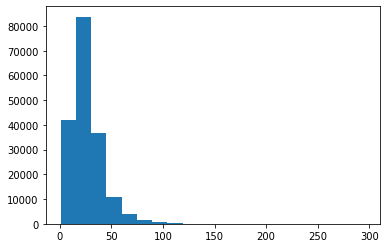

In [227]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [228]:
# How long of a setnence lenght covers 95% of examples?
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len

55

In [229]:
#Maximum sequence length 
max(sent_lens)

296

#Create text vectorizer layer

In [230]:
#How many words are in vocab?(based on Dataset Paper)
max_tokens=68000

In [231]:
#create vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer=TextVectorization(max_tokens=max_tokens,output_sequence_length=output_seq_len)

In [232]:
#Adapt text_vectorizer to train Sentences
text_vectorizer.adapt(train_sentences)

In [233]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
conventional dl and videolaryngoscopy are suitable modes for intubating extremely preterm baboons .

Length of text: 13

Vectorized text: [[  366  6107     3 24119    58  2532  4578    11  7852  3945  1184 40882
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [234]:
#how many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [235]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization_2',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

#text Embedding layer

In [236]:
from tensorflow.keras import layers

In [237]:
#create token embedding 
token_embed=layers.Embedding(input_dim=len(rct_20k_text_vocab),output_dim=128,mask_zero=True,name="token_embeddig")
# different embedding sizes result in drastically differnt numbers of parameters to train

In [238]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 conventional dl and videolaryngoscopy are suitable modes for intubating extremely preterm baboons .

Sentence after vectorization (before embedding):
 [[  366  6107     3 24119    58  2532  4578    11  7852  3945  1184 40882
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.00033789 -0.00189909 -0.04115869 ...  0.01801315 -0.00454527
   -0.04231769]
  [ 0.03390903 -0.03517827  0.00097334 ...  0.04832033 -0.01022841
   -0.04122046]
  [-0.01950468 -0.00102577 -0.02877579 ... -0.00886738  0.00608696
    0.02865708]
  ...
  [-0.00880859 -0.03170614  0.02308181 ... -0.04129447  0.04111269
    0.03709296]
  [-0.00880859 -0.03170614  0.02308181 ... -0.04129447  0.04111269
    0.03709296]
  [-0.00880859 -0.03170614

#Creating datasets

In [239]:
#Turn our data into Tensorflow Datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))


In [240]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [241]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#Model1 :Cov1D with token embedding

In [242]:
#Create 1D conv model
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(inputs)
token_embeddings=token_embed(text_vectors)
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_1=tf.keras.Model(inputs,outputs)
#compile
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])


In [243]:
model_1.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embeddig (Embedding)  (None, 55, 128)           8299648   
                                                                 
 conv1d_4 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_22 (Dense)            (None, 5)                 325

In [244]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 6s 9ms/step - loss: 0.9148 - accuracy: 0.6415 - val_loss: 0.6842 - val_accuracy: 0.7427
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6589 - accuracy: 0.7542 - val_loss: 0.6284 - val_accuracy: 0.7696
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6187 - accuracy: 0.7734 - val_loss: 0.5958 - val_accuracy: 0.7852


In [245]:
#evaluate on whole dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5986 - accuracy: 0.7858


[0.5985977053642273, 0.7858467102050781]

In [246]:
#make predictions 
model_1_pred_probs=model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.0205467e-01, 1.8177274e-01, 9.5256045e-02, 2.9274803e-01,
        2.8168490e-02],
       [4.5092794e-01, 2.6956350e-01, 1.5855461e-02, 2.5597870e-01,
        7.6743434e-03],
       [1.6867404e-01, 7.9246685e-03, 1.9720034e-03, 8.2139468e-01,
        3.4667508e-05],
       ...,
       [4.7437147e-06, 6.2155345e-04, 6.9484179e-04, 3.7264676e-06,
        9.9867505e-01],
       [5.8770198e-02, 4.2922848e-01, 1.3496508e-01, 6.4741373e-02,
        3.1229484e-01],
       [1.6668113e-01, 6.7844796e-01, 4.0058274e-02, 4.3125823e-02,
        7.1686819e-02]], dtype=float32)

In [247]:
# Convert pred probs to classes

model_1_preds=tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [248]:
class_names


array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [249]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.5846683437045,
 'f1': 0.7833246823108988,
 'precision': 0.7824227597139188,
 'recall': 0.7858466834370449}

#model 2 : Feature extraction with pretrained token embeddings

In [250]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [251]:
# Test out the pretrained embedding on a random sentence 
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Setence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 randomized , controlled , clinical trial .
Setence after embedding:
[-0.00575573  0.00321558 -0.0312764  -0.00127467  0.02307955 -0.00650592
  0.02481956 -0.00675203  0.043786    0.01204304  0.08241668 -0.02056322
  0.06950611 -0.02852193  0.04828175 -0.03639397 -0.08273845  0.04588051
  0.01308774 -0.05135726 -0.04449932  0.02516262 -0.06170818  0.00827965
  0.00620543 -0.06549652 -0.02459541  0.07949456 -0.05064601  0.02429411]

Length of sentence embedding: 512


In [252]:
# tokenize text and create embedding of each sequence (512 long vector)
inputs=layers.Input(shape=[],dtype=tf.string)#
pretrained_embeddig=tf_hub_embedding_layer(inputs)## tokenize text and create embedding of each sequence (512 long vector)
x=layers.Dense(128,activation="relu")(pretrained_embeddig)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model2=tf.keras.Model(inputs,outputs,name="model2_feature_extarction")
#compile the model
model2.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [253]:
model2.summary()

Model: "model2_feature_extarction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_23 (Dense)            (None, 128)               65664     
                                                                 
 dense_24 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [254]:
#fit model 2 
history_2=model2.fit(train_dataset,epochs=3,steps_per_epoch=(0.1*len(train_dataset)),validation_data=valid_dataset,validation_steps=(0.1*(len(valid_dataset))))

Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9168 - accuracy: 0.6504 - val_loss: 0.8026 - val_accuracy: 0.6872
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7698 - accuracy: 0.7018 - val_loss: 0.7585 - val_accuracy: 0.7007
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7528 - accuracy: 0.7120 - val_loss: 0.7433 - val_accuracy: 0.7112


In [255]:
model2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7432 - accuracy: 0.7138


[0.7432054877281189, 0.7138223052024841]

In [256]:
#Make predictions
model2_pred_probs=model2.predict(valid_dataset)
model2_pred_probs

array([[0.42284155, 0.34730855, 0.00213456, 0.21925046, 0.00846486],
       [0.3338322 , 0.5188256 , 0.00339767, 0.1419047 , 0.00203982],
       [0.21596473, 0.14587645, 0.01933146, 0.5782656 , 0.04056169],
       ...,
       [0.00186054, 0.00614991, 0.05551789, 0.00095391, 0.9355177 ],
       [0.00483659, 0.05077586, 0.24448517, 0.00211665, 0.6977857 ],
       [0.1802752 , 0.2572453 , 0.49666658, 0.00619087, 0.05962197]],
      dtype=float32)

In [257]:
#Convert the prediction probabilities 
model2_preds=tf.argmax(model2_pred_probs,axis=1)
model2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [258]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model2_preds)
model_2_results

{'accuracy': 71.38223222560572,
 'f1': 0.7110174952647724,
 'precision': 0.7145077089777493,
 'recall': 0.7138223222560572}

#Model3 with Character embeddings

In [259]:
#Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

split_chars(random_train_sentence)  

'r a n d o m i z e d   ,   c o n t r o l l e d   ,   c l i n i c a l   t r i a l   .'

In [260]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [261]:
#What is the Average character length?
chars_len=[len(sentence) for  sentence in train_sentences]
mean_char_len=np.mean(chars_len)
mean_char_len

149.3662574983337

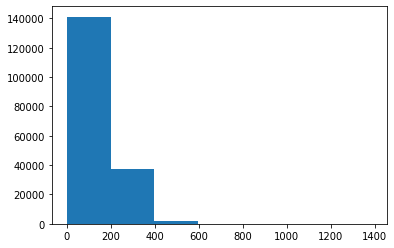

In [262]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(chars_len, bins=7);

In [263]:
#Find the character length covers 95% of sequence
output_seq_char_len = int(np.percentile(chars_len, 95))
output_seq_char_len

290

In [264]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [265]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None, # set standardization to "None" if you want to leave punctuation in
                                    name="char_vectorizer")

In [266]:
#Adapt character vectorizer to train characters
char_vectorizer.adapt(train_chars)

In [267]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [268]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 o n   d a y   @   ,   t h e   p e r m e t h r i n - r e s i s t a n t   h a p l o t y p e   w a s   s i g n i f i c a n t l y   m o r e   f r e q u e n t   i n   t h e   p e r m e t h r i n   g r o u p   t h a n   i n   t h e   p l a c e b o   g r o u p   (   @   %   v s   @   %   ,   p   <   @   )   .

Length of random_train_chars: 121

Vectorized chars:
 [[ 7  6 10  5 19  3 13  2 14  2  8 15  2  3 13  8  4  6  8  2  9  4  9  3
   5  6  3 13  5 14 12  7  3 19 14  2 20  5  9  9  4 18  6  4 17  4 11  5
   6  3 12 19 15  7  8  2 17  8  2 26 16  2  6  3  4  6  3 13  2 14  2  8
  15  2  3 13  8  4  6 18  8  7 16 14  3 13  5  6  4  6  3 13  2 14 12  5
  11  2 22  7 18  8  7 16 14 21  9 14  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0 

In [269]:
#Creating a character-level embedding
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf (Figure 1)
                              mask_zero=True,
                              name="char_embed")

In [270]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 o n   d a y   @   ,   t h e   p e r m e t h r i n - r e s i s t a n t   h a p l o t y p e   w a s   s i g n i f i c a n t l y   m o r e   f r e q u e n t   i n   t h e   p e r m e t h r i n   g r o u p   t h a n   i n   t h e   p l a c e b o   g r o u p   (   @   %   v s   @   %   ,   p   <   @   )   .

Embedded chars (after vectorization and embedding):
 [[[-0.00419295 -0.01452764 -0.00143181 ...  0.04482025  0.0435666
    0.00432967]
  [-0.02936614  0.02516985 -0.04058015 ...  0.04013895  0.03622438
   -0.03492422]
  [ 0.00614157 -0.0021535  -0.00319552 ...  0.04562081 -0.04970247
   -0.0487791 ]
  ...
  [ 0.03174073  0.02145329 -0.00513343 ... -0.02740874  0.01241164
    0.02630955]
  [ 0.03174073  0.02145329 -0.00513343 ... -0.02740874  0.01241164
    0.02630955]
  [ 0.03174073  0.02145329 -0.00513343 ... -0.02740874  0.01241164
    0.02630955]]]

Character embedding shape: (1, 290, 25)


#Conv2D model on Chars only

In [271]:
#Make Conv1D model on chars only 
inputs=layers.Input(shape=(1,),dtype="string")
char_vectors=char_vectorizer(inputs)
char_embeddings=char_embed(char_vectors)
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(char_embeddings)
x=layers.GlobalMaxPool1D()(x)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model3=tf.keras.Model(inputs,outputs,name='model_with_char_embedding')
#compile the model
model3.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [272]:
model3.summary()

Model: "model_with_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_5 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_25 (Dense)            (None, 5)   

In [273]:
#Create char level dataset

train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [274]:
# Fit the model on chars only
model_3_history = model3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2562 - accuracy: 0.4893 - val_loss: 1.0361 - val_accuracy: 0.5924
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9911 - accuracy: 0.6056 - val_loss: 0.9239 - val_accuracy: 0.6413
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9068 - accuracy: 0.6459 - val_loss: 0.8593 - val_accuracy: 0.6672


In [275]:
#Make Predictions with char model
model3_pred_probs=model3.predict(val_char_dataset)
model3_pred_probs


array([[0.10988712, 0.34031084, 0.12088612, 0.38920546, 0.03971042],
       [0.2566815 , 0.45094332, 0.00376931, 0.25631148, 0.03229439],
       [0.04854811, 0.3145828 , 0.27233836, 0.2956063 , 0.06892446],
       ...,
       [0.04112754, 0.05958894, 0.21555011, 0.02692509, 0.6568084 ],
       [0.03372529, 0.20921294, 0.18597068, 0.04747092, 0.5236201 ],
       [0.26930013, 0.5063612 , 0.14494933, 0.04708536, 0.03230394]],
      dtype=float32)

In [276]:
model3_preds=tf.argmax(model3_pred_probs,axis=1)
model3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 1, ..., 4, 4, 1])>

In [277]:

# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model3_preds)
model_3_results

{'accuracy': 66.42393750827486,
 'f1': 0.65630655362137,
 'precision': 0.6613571115811627,
 'recall': 0.6642393750827486}

#Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

In [278]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

#5-construct model with char and token inputs 
model4=tf.keras.Model(inputs=[token_model.input,char_model.input],outputs=output_layer,name='model4_token_char_ebeddings')

In [279]:
model4.summary()

Model: "model4_token_char_ebeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token

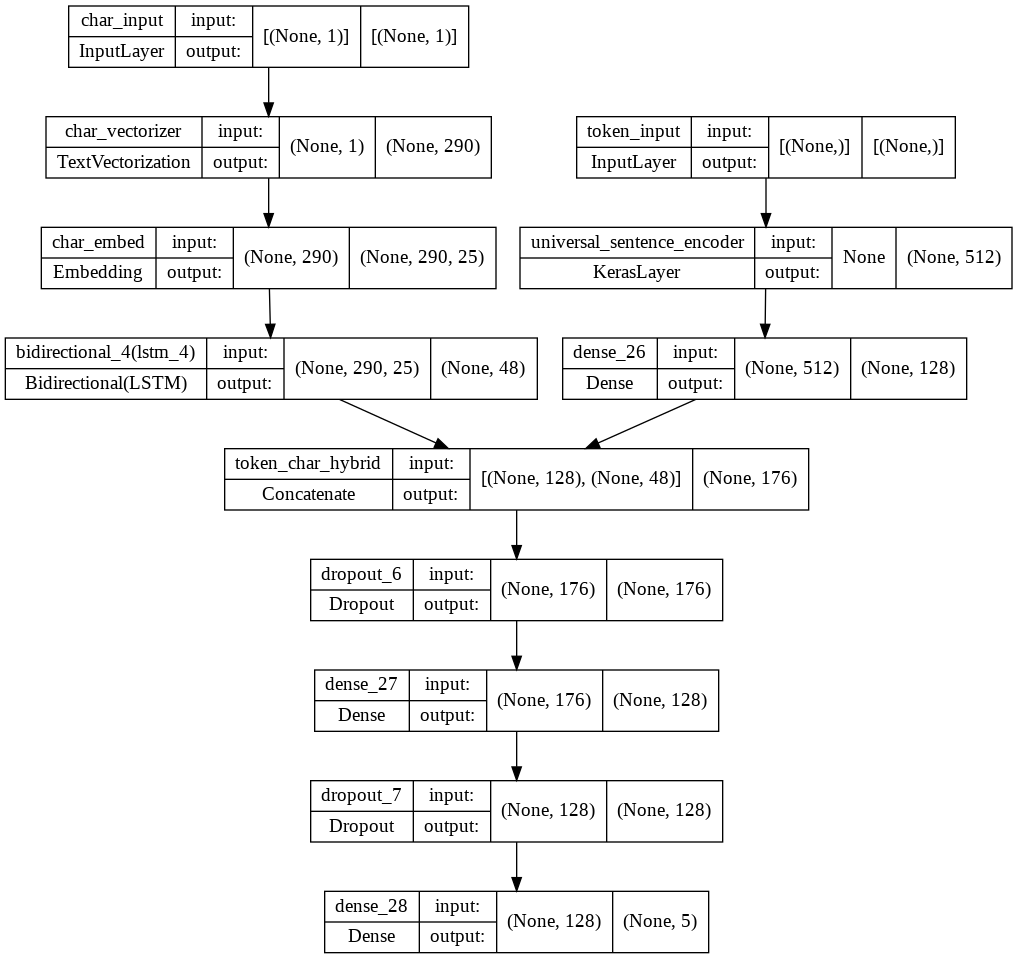

In [280]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model4,show_shapes=True)

In [281]:
#Compile the model
model4.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])


##Combining token and character data into a tf.data Dataset

In [282]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [283]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [284]:
#check out training char and token embeddings dataset
train_char_token_dataset,val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

##fitting model 

In [285]:
#fit the model
history_model4=model4.fit(train_char_token_dataset,steps_per_epoch=(0.1*len(val_char_token_dataset)),epochs=3,validation_data=val_char_token_dataset,validation_steps=(0.1*len(val_char_token_dataset)))

Epoch 1/3
94/94 [==============================] - 17s 87ms/step - loss: 1.3313 - accuracy: 0.4329 - val_loss: 1.0516 - val_accuracy: 0.5543
Epoch 2/3
94/94 [==============================] - 8s 84ms/step - loss: 1.0323 - accuracy: 0.5934 - val_loss: 0.8871 - val_accuracy: 0.6395
Epoch 3/3
94/94 [==============================] - 7s 73ms/step - loss: 0.9637 - accuracy: 0.6151 - val_loss: 0.8419 - val_accuracy: 0.6661


In [286]:
#evaluation
model4.evaluate(val_char_token_dataset)


945/945 [==============================] - 23s 24ms/step - loss: 0.8366 - accuracy: 0.6727


[0.8365878462791443, 0.6727128028869629]

In [287]:
#Make prediction 
model4_pred_probs=model4.predict(val_char_token_dataset)
model4_pred_probs

array([[0.31340042, 0.4357439 , 0.0314491 , 0.18323691, 0.03616977],
       [0.33179447, 0.47839966, 0.0164556 , 0.1541788 , 0.01917149],
       [0.2625069 , 0.3274197 , 0.05184719, 0.30063242, 0.05759386],
       ...,
       [0.00197565, 0.01158067, 0.09560533, 0.00142778, 0.8894106 ],
       [0.00947862, 0.03918738, 0.39775375, 0.00640983, 0.5471704 ],
       [0.16992573, 0.10091919, 0.5519623 , 0.04741133, 0.12978144]],
      dtype=float32)

In [288]:
#Format pred probs into pred labels 
model4_preds=tf.argmax(model4_pred_probs,axis=1)
model4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 2])>

In [289]:
#Result of hybrid model 


model4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model4_preds)
model4_results

{'accuracy': 67.27128293393353,
 'f1': 0.6603092827240434,
 'precision': 0.6688458279009453,
 'recall': 0.6727128293393354}

#Model5 Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

###create positional embedding 

In [290]:
#How many diffrent lines we have ?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [305]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

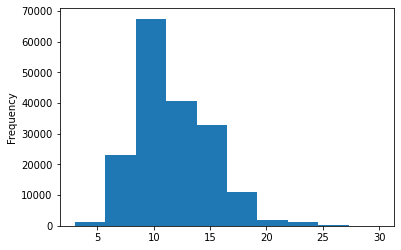

In [306]:
# Check the distributions of total lines
train_df.total_lines.plot.hist();

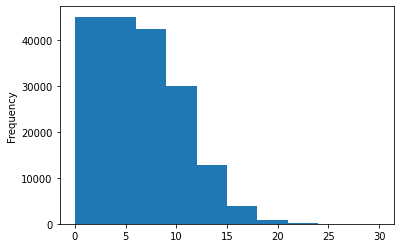

In [291]:
#check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [301]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

###Building a tribid embedding model 
1-Create a token-level model
2-Create a character-level model
3-Create a model for the "line_number" feature
4-Create a model for the "total_lines" feature
5-Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6-Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7-Create an output layer to accept the tribrid embedding and output label probabilities
8-Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model



In [293]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
# inputs, shape = ?
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
# dense layer with 32 units & relu activation
x = layers.Dense(32, activation="relu")(line_number_inputs)
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [294]:
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

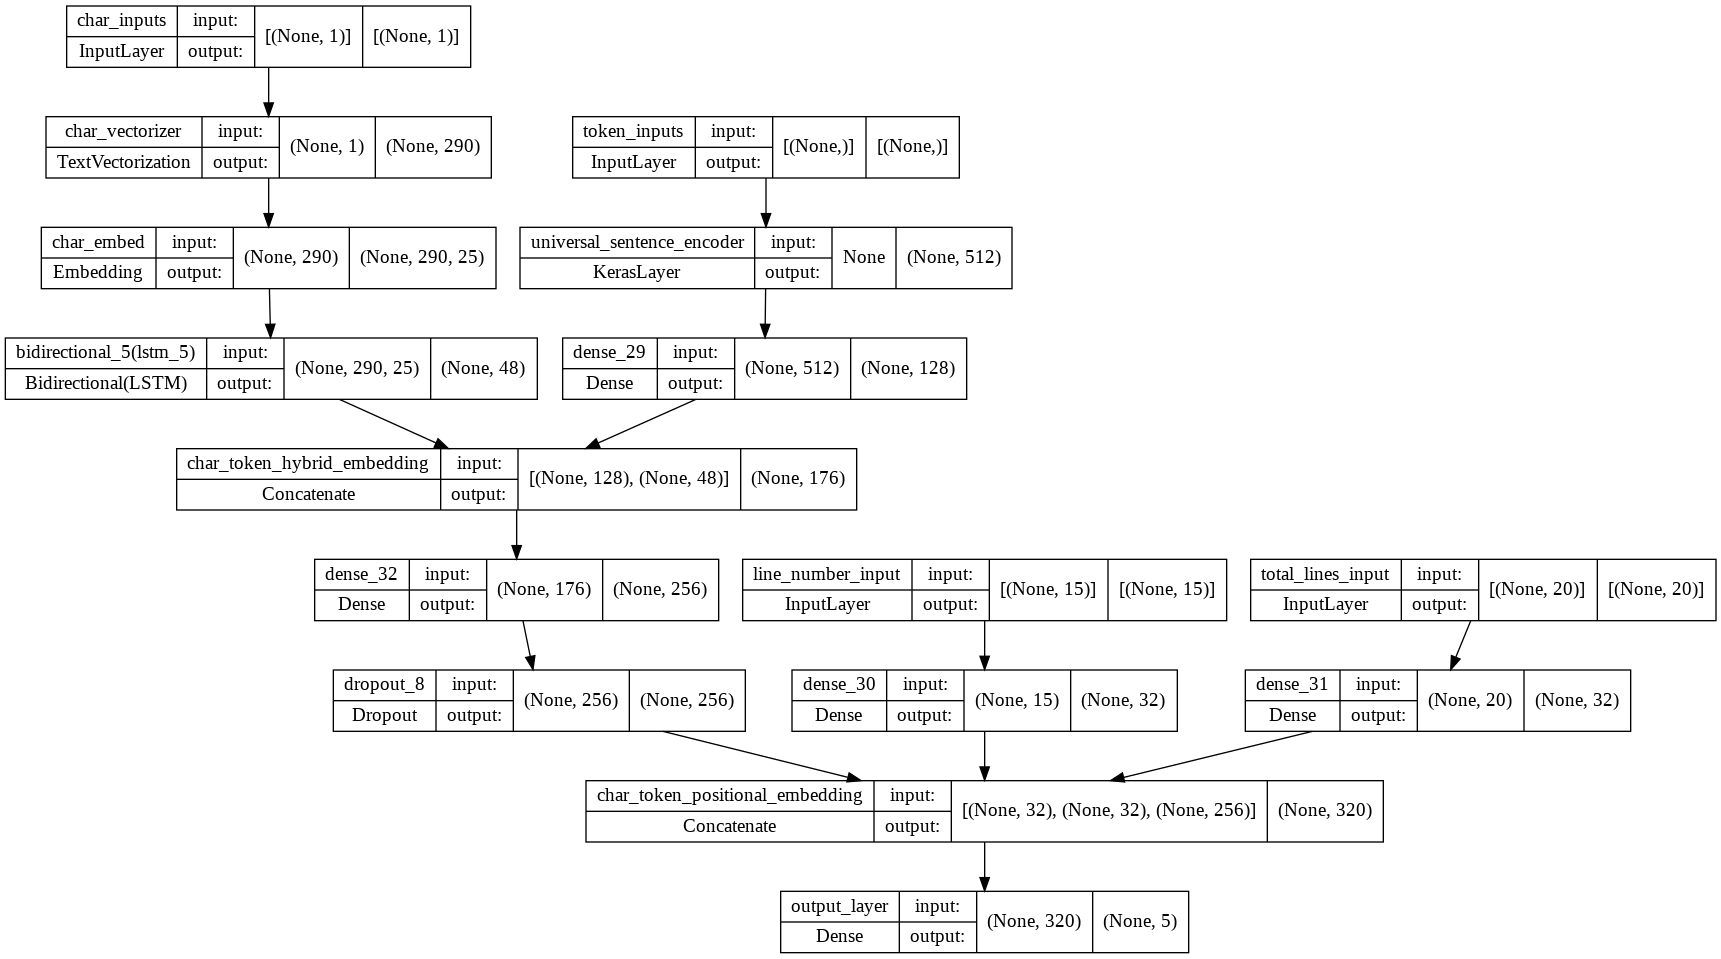

In [295]:
# Plot model_5 to explore it visually...
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [296]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

###Create tribrid embedding datasets using tf.data

In [307]:
# Create training and valiadation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [308]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

###Fitting and evaluating and prediction the model

In [309]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 46s 63ms/step - loss: 1.0942 - accuracy: 0.7262 - val_loss: 0.9819 - val_accuracy: 0.7995
Epoch 2/3
562/562 [==============================] - 45s 81ms/step - loss: 0.9670 - accuracy: 0.8161 - val_loss: 0.9488 - val_accuracy: 0.8248
Epoch 3/3
562/562 [==============================] - 41s 74ms/step - loss: 0.9488 - accuracy: 0.8241 - val_loss: 0.9389 - val_accuracy: 0.8305


In [310]:
#Make predictions
model5_pred_porbs=model_5.predict(val_char_token_pos_dataset,verbose=1)
model5_pred_porbs

945/945 [==============================] - 39s 36ms/step


In [311]:
#Convert pred probs to pred labels
model_5_preds=tf.argmax(model5_pred_porbs,axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [312]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.29802727393088,
 'f1': 0.8319674532772194,
 'precision': 0.8321643612679719,
 'recall': 0.8329802727393089}

#Compare model results


In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

In [314]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": base_line_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.584668,0.782423,0.785847,0.783325
model_2_pretrained_token_embedding,71.382232,0.714508,0.713822,0.711017
model_3_custom_char_embedding,66.423938,0.661357,0.664239,0.656307
model_4_hybrid_char_token_embedding,67.271283,0.668846,0.672713,0.660309
model_5_pos_char_token_embedding,83.298027,0.832164,0.832980,0.831967


In [315]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

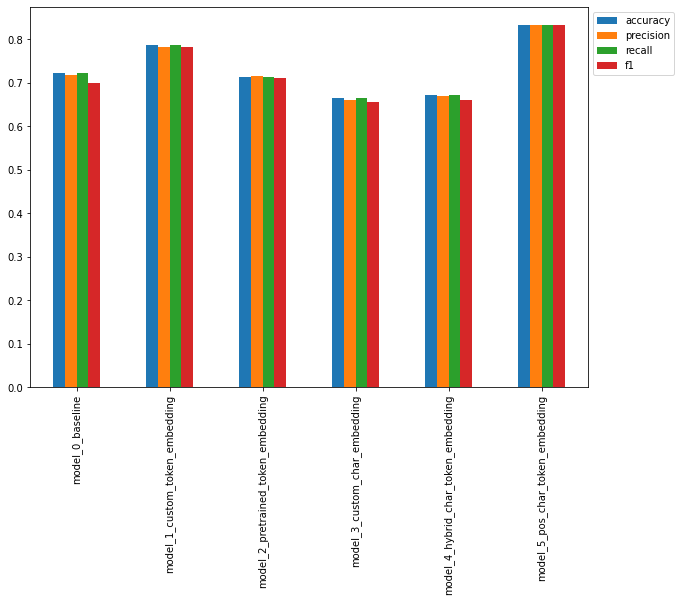

In [316]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

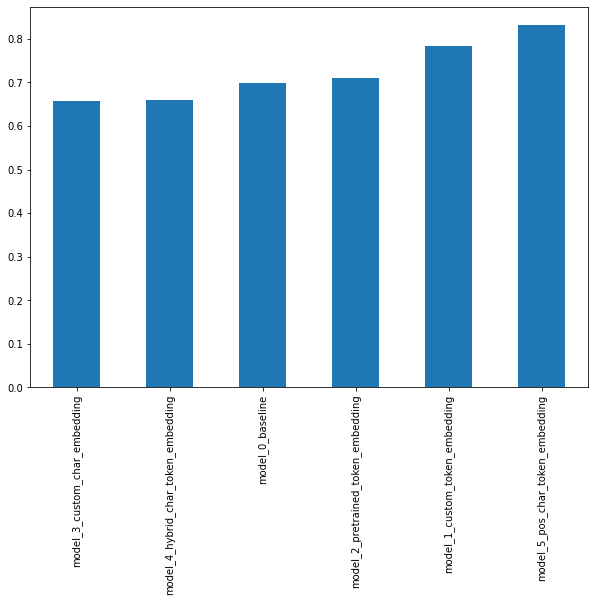

In [317]:
# Sort models results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7));